# 1. Import

In [17]:
# Basic Library
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

In [8]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
submission = pd.read_csv("../data/sample_submission.csv")

In [9]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [10]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Created Directory :", dir)
    else:
        print("Directory already existed :", dir)
create_dir("../pickle")
create_dir("../model")
create_dir("../submission")

Created Directory : ../pickle
Created Directory : ../model
Directory already existed : ../submission


In [11]:
train.dtypes

Gender             object
Lenght            float64
Diameter          float64
Height            float64
Whole Weight      float64
Shucked Weight    float64
Viscra Weight     float64
Shell Weight      float64
Target              int64
dtype: object

In [12]:
rows_train = train.shape[0] # 주어진 train data의 row 수
rows_test = test.shape[0] # 주어진 test data의 row 수
num_trial = 20 # 파라미터 튜닝을 몇 번 진행하는지의 수
splits_hp = 10 # 파라미터 튜닝을 진행할 때의 kfold 수
splits_tr = 15 # 모델 트레이닝을 진행할 때의 kfold 수
basic_seed = 42 # default seed
num_seed = 10 # 트레이닝 seed 개수
sel_seed = 3 # 선택할 seed 개수

# 2. Data Preprocessing

In [13]:
train_lab = train.copy()
test_lab = test.copy()

enc = LabelEncoder()
for col in train_lab.columns:
    if train_lab[col].dtypes=='object':
        train_lab[col] = enc.fit_transform(train_lab[col])
        test_lab[col] = enc.fit_transform(test_lab[col])

train_x = train_lab.drop(['Target'], axis=1) # 데이터 나누기
train_y = train_lab['Target']
test_x = test_lab.copy()

print('Label Encoding Completed')

Label Encoding Completed


# 3. Modeling

In [30]:
pred_dict = {}
pred_test_dict = {}

## (1) LightGBM

In [14]:
def lgb_objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": basic_seed,
        "verbosity": -1,
        "n_estimators": 10000,
        'learning_rate': trial.suggest_uniform("learning_rate", 0.001, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
#         "reg_alpha": trial.suggest_uniform("reg_alpha", 0.0, 0.5),
#         "reg_lambda": trial.suggest_uniform("reg_lambda", 0.0, 0.5),
         "num_leaves": trial.suggest_int("num_leaves", 31, 500),
#         "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0), # feature_fraction
#         "subsample": trial.suggest_uniform("subsample", 0.1, 1.0),
#         "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
#         "min_child_samples": trial.suggest_int("min_child_samples", 1, 10),
#         "max_bin": trial.suggest_int("max_bin", 150, 400),
    }
    
    kfold = StratifiedKFold(n_splits=splits_hp, random_state=basic_seed, shuffle=True) # Cross-validation cv=5
    cv = np.zeros(rows_train)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values, train_y.iloc[val_idx].values

        lgbmodel = LGBMRegressor(**params_lgb)
                                                                                        # 진행상황 보고싶을때 -1을 100으로
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=10, verbose=-1) 
        cv[val_idx] = lgbmodel.predict(x_val)
        
    print('MAE:', mean_absolute_error(train_y, cv))
    return mean_absolute_error(train_y, cv)

In [23]:
def lgb_objective(trial: Trial) -> float:
    score_hp = []
    for seed_hp in np.random.randint(0, 1000, 5):
        params_lgb = {
            "random_state": seed_hp,
            "verbosity": -1,
            "n_estimators": 10000,
            'learning_rate': trial.suggest_uniform("learning_rate", 1e-4, 0.1),
            "max_depth": trial.suggest_int("max_depth", 2, 10),
            "reg_alpha": trial.suggest_uniform("reg_alpha", 0.0, 0.5),
            "reg_lambda": trial.suggest_uniform("reg_lambda", 0.0, 0.5),
             "num_leaves": trial.suggest_int("num_leaves", 31, 1500),
            "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0), # feature_fraction
            "subsample": trial.suggest_uniform("subsample", 0.1, 1.0),
            "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 10),
            "max_bin": trial.suggest_int("max_bin", 150, 400),
        }

        kfold = StratifiedKFold(n_splits=splits_hp, random_state=basic_seed, shuffle=True) # Cross-validation cv=5
        cv = np.zeros(rows_train)

        for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

            x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
            y_train, y_val = train_y.iloc[train_idx].values, train_y.iloc[val_idx].values

            lgbmodel = LGBMRegressor(**params_lgb)
                                                                                            # 진행상황 보고싶을때 -1을 100으로
            lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=None) 
            cv[val_idx] = lgbmodel.predict(x_val)
            
        score_hp.append(mean_absolute_error(train_y, cv))
    
    np.mean(score_hp)
#     pred_hp_dict['lgb'+str(seed)] = cv
#     print(f'seed {seed}', 'mean_absolute_error :', mean_absolute_error(train_y, cv))
    
#     return mean_absolute_error(train_y, cv)
    return np.mean(score_hp)

In [25]:
sampler = TPESampler(seed=basic_seed)
lgb_study = optuna.create_study(study_name="lgb_parameter_opt", direction="minimize", sampler=sampler)
lgb_study.optimize(lgb_objective, n_trials=50)

lgb_best_hyperparams = lgb_study.best_trial.params
lgb_base_hyperparams = {'n_estimators':10000,
#                         'lambda_l1':lgb_best_hyperparams['reg_alpha'],
#                         'lambda_l2':lgb_best_hyperparams['reg_lambda']
                       }
lgb_best_hyperparams.update(lgb_base_hyperparams)
print("The best hyperparameters are:\n", lgb_best_hyperparams)

[I 2022-03-21 16:01:25,755] A new study created in memory with name: lgb_parameter_opt
[I 2022-03-21 16:01:28,879] Trial 0 finished with value: 1.5987833214561558 and parameters: {'learning_rate': 0.03751655787285152, 'max_depth': 10, 'reg_alpha': 0.36599697090570255, 'reg_lambda': 0.2993292420985183, 'num_leaves': 260, 'colsample_bytree': 0.5779972601681014, 'subsample': 0.15227525095137953, 'subsample_freq': 9, 'min_child_samples': 7, 'max_bin': 327}. Best is trial 0 with value: 1.5987833214561558.
[I 2022-03-21 16:02:26,554] Trial 1 finished with value: 1.5774568997490348 and parameters: {'learning_rate': 0.0021563909801506644, 'max_depth': 10, 'reg_alpha': 0.41622132040021087, 'reg_lambda': 0.10616955533913808, 'num_leaves': 298, 'colsample_bytree': 0.5917022549267169, 'subsample': 0.373818018663584, 'subsample_freq': 6, 'min_child_samples': 5, 'max_bin': 223}. Best is trial 1 with value: 1.5774568997490348.
[I 2022-03-21 16:02:28,108] Trial 2 finished with value: 1.594756366084574

[I 2022-03-21 16:03:48,281] Trial 19 finished with value: 1.5858593565183774 and parameters: {'learning_rate': 0.046238171050730296, 'max_depth': 4, 'reg_alpha': 0.0736306798333981, 'reg_lambda': 0.0024210522183227418, 'num_leaves': 1497, 'colsample_bytree': 0.5502433160347462, 'subsample': 0.46142245979696184, 'subsample_freq': 5, 'min_child_samples': 7, 'max_bin': 368}. Best is trial 18 with value: 1.5595122367020713.
[I 2022-03-21 16:03:51,654] Trial 20 finished with value: 1.5840647676435122 and parameters: {'learning_rate': 0.06849268797524583, 'max_depth': 8, 'reg_alpha': 0.32705867526833776, 'reg_lambda': 0.10696522698760919, 'num_leaves': 1281, 'colsample_bytree': 0.6165604167672804, 'subsample': 0.45385049765819757, 'subsample_freq': 8, 'min_child_samples': 8, 'max_bin': 361}. Best is trial 18 with value: 1.5595122367020713.
[I 2022-03-21 16:03:55,657] Trial 21 finished with value: 1.5641663913378108 and parameters: {'learning_rate': 0.027658030609078444, 'max_depth': 5, 'reg_

[I 2022-03-21 16:07:19,045] Trial 38 finished with value: 1.5789795284734804 and parameters: {'learning_rate': 0.005228924729344548, 'max_depth': 6, 'reg_alpha': 0.02118880241681123, 'reg_lambda': 0.23431806414500367, 'num_leaves': 383, 'colsample_bytree': 0.5457866720299651, 'subsample': 0.40082428831888706, 'subsample_freq': 2, 'min_child_samples': 10, 'max_bin': 353}. Best is trial 33 with value: 1.554896669172634.
[I 2022-03-21 16:07:33,029] Trial 39 finished with value: 1.5682936317125908 and parameters: {'learning_rate': 0.009018346003443502, 'max_depth': 9, 'reg_alpha': 0.057787242413329595, 'reg_lambda': 0.1518066740328437, 'num_leaves': 355, 'colsample_bytree': 0.6076294911143445, 'subsample': 0.3513407297332158, 'subsample_freq': 7, 'min_child_samples': 9, 'max_bin': 373}. Best is trial 33 with value: 1.554896669172634.
[I 2022-03-21 16:08:11,607] Trial 40 finished with value: 1.5807103568416827 and parameters: {'learning_rate': 0.0013745301647146053, 'max_depth': 4, 'reg_alp

The best hyperparameters are:
 {'learning_rate': 0.010667936776734324, 'max_depth': 6, 'reg_alpha': 0.03570103456629391, 'reg_lambda': 0.19672233720229004, 'num_leaves': 242, 'colsample_bytree': 0.5877936120135464, 'subsample': 0.40556577983352177, 'subsample_freq': 2, 'min_child_samples': 10, 'max_bin': 400, 'n_estimators': 10000}


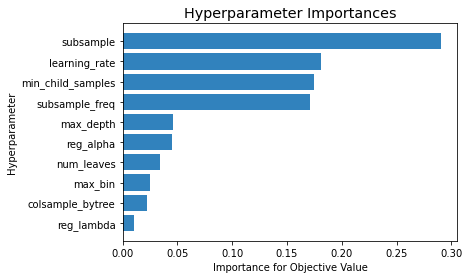

In [26]:
optuna.visualization.matplotlib.plot_param_importances(lgb_study);

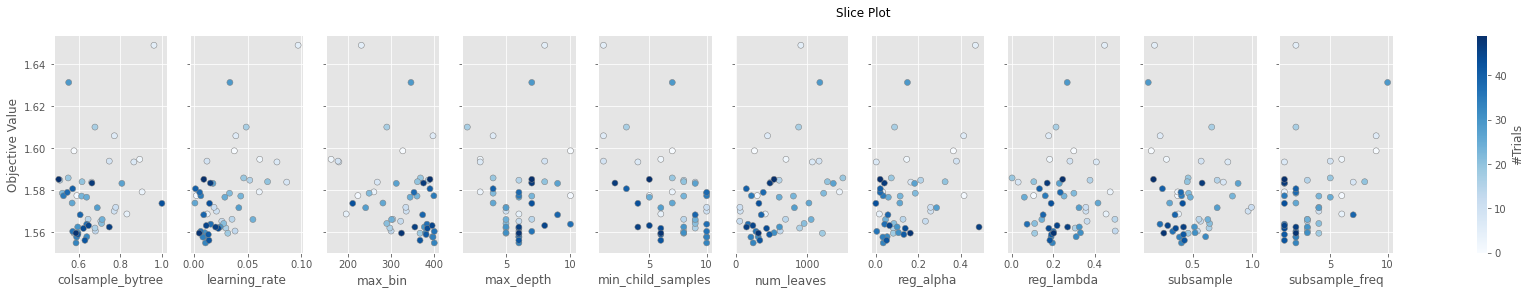

In [27]:
optuna.visualization.matplotlib.plot_slice(lgb_study);

In [31]:
lucky_seeds = np.random.randint(0, 1000, num_seed)

for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=splits_tr, random_state=seed, shuffle=True) # CV 늘려가면서 하기
    cv = np.zeros(rows_train)
    pred_test = np.zeros(rows_test)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        
        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()

        lgbmodel = LGBMRegressor(**lgb_best_hyperparams)
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=30, verbose=None)
        
        cv[val_idx] = lgbmodel.predict(x_val)
        pred_test += lgbmodel.predict(test_x) / splits_tr
        
    pred_dict['lgb'+str(seed)] = cv
    pred_test_dict['lgb'+str(seed)] = pred_test
    print(f'seed {seed}', 'mean_absolute_error :', mean_absolute_error(train_y, cv))

seed 836 mean_absolute_error : 1.5649276459480805
seed 743 mean_absolute_error : 1.5599816614894093
seed 871 mean_absolute_error : 1.5683828208028474
seed 699 mean_absolute_error : 1.5544754326975236
seed 363 mean_absolute_error : 1.5488832377770976
seed 23 mean_absolute_error : 1.5635668464905432
seed 86 mean_absolute_error : 1.5616203009307843
seed 901 mean_absolute_error : 1.551505830342373
seed 567 mean_absolute_error : 1.5539418661714364
seed 313 mean_absolute_error : 1.5535224851533807


In [46]:
pred = (pred_test_dict['lgb363'] + pred_test_dict['lgb901'] + pred_test_dict['lgb313'] + pred_test_dict['lgb567']) / 4

In [39]:
def sort_dict(model, pred_dict, pred_test_dict):
    pred_dict_local = {}
    for key, value in pred_dict.items():
        if model in key:
            pred_dict_local[key]=value

    pred_test_dict_local = {}
    for key, value in pred_test_dict.items():
        if model in key:
            pred_test_dict_local[key]=value

    pred_dict_new_local = dict(sorted(
        pred_dict_local.items(), 
        key=lambda x:mean_absolute_error((train_y), 
                                    np.argmax(list(x[1]), axis=1)), reverse=False)[:sel_seed])
    pred_test_dict_new_local = {}
    for key, value in pred_dict_new_local.items():
        pred_test_dict_new_local[key]=pred_test_dict_local[key]
        
    return pred_dict_new_local, pred_test_dict_new_local

In [40]:
pred_dict_lgb, pred_test_dict_lgb = sort_dict('lgb', pred_dict, pred_test_dict)
pred_dict_xgb, pred_test_dict_xgb = sort_dict('xgb', pred_dict, pred_test_dict)
pred_dict_cnn, pred_test_dict_cnn = sort_dict('cnn', pred_dict, pred_test_dict)
pred_dict_rcnn, pred_test_dict_rcnn = sort_dict('rcnn', pred_dict, pred_test_dict)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
def save_dict(model, pred_dict, pred_test_dict):
    with open('../pkl/pred_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_dict, fw)
    with open('../pkl/pred_test_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_test_dict, fw)

In [ ]:
save_dict('lgb', pred_dict_lgb, pred_test_dict_lgb)
save_dict('xgb', pred_dict_xgb, pred_test_dict_xgb)
save_dict('cnn', pred_dict_cnn, pred_test_dict_cnn)
save_dict('rcnn', pred_dict_rcnn, pred_test_dict_rcnn)

In [ ]:
def load_dict(model):
    with open('../pkl/pred_dict_'+model+'.pickle', 'rb') as fw:
        pred_dict_new_local = pickle.load(fw)
    with open('../pkl/pred_test_dict_'+model+'.pickle', 'rb') as fw:
        pred_test_dict_new_local = pickle.load(fw)    
    return pred_dict_new_local, pred_test_dict_new_local

In [ ]:
pred_dict_lgb, pred_test_dict_lgb = load_dict('lgb')
pred_dict_xgb, pred_test_dict_xgb = load_dict('xgb')
pred_dict_cnn, pred_test_dict_cnn = load_dict('cnn')
pred_dict_rcnn, pred_test_dict_rcnn = load_dict('rcnn')

In [ ]:
pred_dict_total = {**pred_dict_lgb, **pred_dict_xgb, **pred_dict_cnn, **pred_dict_rcnn}
pred_test_dict_total = {**pred_test_dict_lgb, **pred_test_dict_xgb, **pred_test_dict_cnn, **pred_test_dict_rcnn}

In [ ]:
pred_test_dict

In [50]:
submission.Target = pred

In [51]:
submission_name = '20220321'
submission_number = '3'
submission.to_csv(f'../submission/{submission_name}-{submission_number}.csv', index = False)